## Environment setup

First it is mandatory to load our environment file, which holds our dataset file path.

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
dataset_path = os.getenv('TASK_DATASET_FILE_PATH')


We then import all the needed libraries, including our produced scripts:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from src.cache import cached
from src.preprocess import interesting_columns

## Preprocessing
We use `chached` from `src.cache`  to load our data, it's a commodity functions which loads or creates then caches a dataframe, saving us much needed time in loading our dataset.  
It produces a `CachedDataFrame` resource, which can be further used to manipulate these cache files.  
For our dataset, we need only the data frame, thus we just `get` it, and print some information.

In [3]:
df = cached(
    dataset_path + '.picke',
    construct = lambda : pd.read_csv(dataset_path, usecols=interesting_columns.keys()).dropna().astype(interesting_columns)
).get()
df.info( verbose=True )

<class 'pandas.core.frame.DataFrame'>
Index: 2331562 entries, 0 to 2331567
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   scontrino_id  int64 
 1   tessera       int64 
 2   r_qta_pezzi   int64 
 3   cod_prod      int64 
 4   descr_prod    object
 5   liv1          int64 
 6   descr_liv1    object
 7   liv2          int64 
 8   descr_liv2    object
 9   liv3          int64 
 10  descr_liv3    object
 11  liv4          int64 
 12  descr_liv4    object
dtypes: int64(8), object(5)
memory usage: 249.0+ MB


We can clearly see that at least **200+ MB** have been allocated.  

The assigned tasks requires us to produce the cross table between customers and products, to further compute clusterization.  
We can compute the amount of memory used by the cross table, using `int64` as cell type:

In [4]:
number_of_cells = df['cod_prod'].nunique() * df['tessera'].nunique()
entry_size = np.int64().itemsize
print(f"The number of entries is {number_of_cells} and it requires {number_of_cells * entry_size *1e-6 :0.2f} MiB of space.")

The number of entries is 182213184 and it requires 1457.71 MiB of space.


Further considerations on the tasks are:
- Many products are bought rarely, these introduce outliers.
- Some products are too common, these would produce trivial and uninteresting results.
- Many users shops rarely, these too will introduce outliers.

We have to analyze better our dataset, then prune these unwanted features.

### Products pruning
We can plot the frequencies of products, using a logarithmic function as the orders of them vastly differ.  
The logarithmic function clearly shows where products get rarely bought, I decided to take the items with frequencies between **$10^{-3}$** and **$10^{-5}$**.

<Figure size 800x600 with 0 Axes>

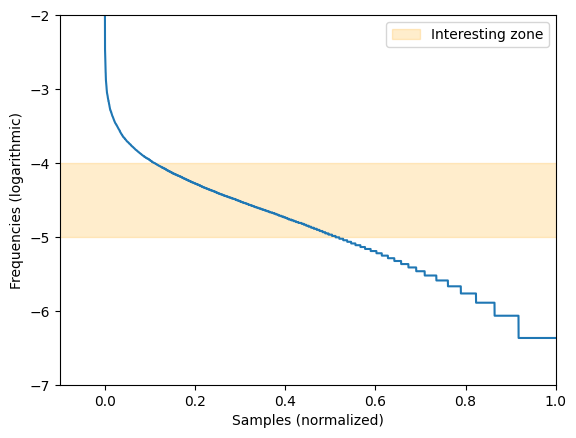

Selected 40% of products. (7817 of 19434)


In [5]:
freqs_ss = df['cod_prod'].value_counts(normalize=True)

pir = (-4, -5)
 
plt.figure(figsize=(8,6))

fig, ax = plt.subplots()


plt.plot( np.linspace(0,1,freqs_ss.size) ,np.log10(freqs_ss.values))

rect = patches.Rectangle(
    (-1, pir[1]), np.abs(pir[0]), 
    np.abs(pir[1]-pir[0]), 
    color='orange', alpha=0.2, label="Interesting zone"
)
plt.ylabel("Frequencies (logarithmic)")
plt.xlabel("Samples (normalized)")

plt.xlim(-.1, 1)
plt.ylim(-7, -2)
ax.add_patch(rect)
plt.legend()
plt.show()

products_ss = freqs_ss[(freqs_ss < 10**pir[0]) & (freqs_ss > 10**pir[1])]
print(f"Selected {products_ss.size/df['cod_prod'].nunique():1.0%} of products. ({products_ss.size} of {df['cod_prod'].nunique()})")

### Customers pruning
As done for products, customer frequencies in logarithmic scale are plotted as follow, I arbitrary choose a minimum support of **10**.

Although this sounds interesting, I decided to not proceed with pruning customers, as little of them are removed and this won't change much further results.  
I leave code and results below out.

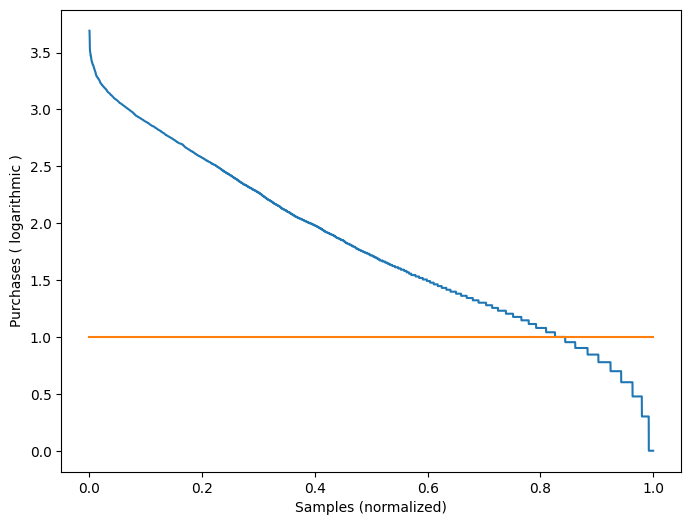

Selected 100% of customers. (9376 of 9376) 


In [ ]:

freqs_ss = df['tessera'].value_counts(normalize=False)


plt.figure(figsize=(8,6))

plt.plot( np.linspace(0,1,freqs_ss.size) ,np.log10(freqs_ss.values))

plt.plot([0,1],[1,1])
plt.ylabel("Purchases ( logarithmic )")
plt.xlabel("Samples (normalized)")

plt.show()

customers_ss = freqs_ss[ (freqs_ss >= 10)]
print(f"Selected {customers_ss.size/df['tessera'].nunique():1.0%} of customers. ({customers_ss.size} of {df['tessera'].nunique()}) ")

The memory footprint of our cross table is:

In [7]:
number_of_cells = customers_ss.size * products_ss.size
entry_size = np.int32().itemsize
print(f"The number of entries is {number_of_cells} and it requires around {number_of_cells * entry_size *1e-6 :0.2f} MiB of space.")

The number of entries is 73292192 and it requires around 293.17 MiB of space.


### Creating the actual dataset
The following code selects all elements of `df` pruning out unfrequent products and occasional customers.

In [14]:
df = df[(df['tessera'].isin(customers_ss.index))]
df

,scontrino_id,tessera,r_qta_pezzi,cod_prod,descr_prod,liv1,descr_liv1,liv2,descr_liv2,liv3,descr_liv3,liv4,descr_liv4
1,52597232,248425239005,1,1090781,1090781 CUKI TEGLIA EXTRA S97 8POR.X2,5,CURA CASA,504,USA E GETTA,50404,SACCHETTI/VASCHETTE ALIMENT,5040402,VASCHETTE
4,52597232,248425239005,1,3000397,3000397 *TEST P.U.GRAM.TEST N/ANT G500,1,DROGHERIA ALIMENTARE,115,PASTA,11506,PASTA ALL'UOVO,1150601,BRODI/MINESTRINE
5,52597232,248425239005,1,3000397,3000397 *TEST P.U.GRAM.TEST N/ANT G500,1,DROGHERIA ALIMENTARE,115,PASTA,11506,PASTA ALL'UOVO,1150601,BRODI/MINESTRINE
10,52597232,248425239005,1,3500912,3500912 TEST SALSA CIL.SIC.FF GR 350,1,DROGHERIA ALIMENTARE,121,DERIVATI DEL POMODORO,12104,PASSATA DI POMODORO,1210402,BOTTIGLIA/VASO
12,52597232,248425239005,1,3500912,3500912 TEST SALSA CIL.SIC.FF GR 350,1,DROGHERIA ALIMENTARE,121,DERIVATI DEL POMODORO,12104,PASSATA DI POMODORO,1210402,BOTTIGLIA/VASO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331546,62223993,248431057006,1,1048171,1048171 BORROMETI SALE IODIOS.FINO KG1,1,DROGHERIA ALIMENTARE,108,INSAPORITORI,10801,SALE,1080101,FINO
2331548,62223995,248431043009,1,1102439,1102439 PITITTU SUPPL.PIZZA MAXI,3,FRESCO,359,BANCO GASTRONOMICO,35901,PREPARATI GASTRONOMIA,3590102,PREPARATI GASTRON.(PANETTERIA)
2331549,62223995,248431043009,1,1101932,1101932 PITITTU PIZZA MAXI SEMPLICE,3,FRESCO,359,BANCO GASTRONOMICO,35901,PREPARATI GASTRONOMIA,3590102,PREPARATI GASTRON.(PANETTERIA)
2331565,62228225,248425239005,1,3501904,3501904 TEST ACETO BIANCO ALCOL! LT.1,1,DROGHERIA ALIMENTARE,105,"OLIO,ACETO E SUCCO DI LIMONE",10501,ACETO,1050101,STANDARD


## Task 1: cross product matrix
We can compute the cross matrix product using DataFrame's method *pivot_table*.

In [9]:
cross_trx = df.pivot_table(index='tessera', columns='cod_prod', values='r_qta_pezzi', aggfunc='sum', fill_value=0).astype('int32')
cross_trx.head(10)

cod_prod,1000013,1000040,1000062,1000102,1000103,1000106,1000109,1000116,1000121,1000136,...,5038748,5038749,5045768,5065294,5069947,5073248,5091106,5100931,5200276,10013191
tessera,,,,,,,,,,,,,,,,,,,,,
248400000002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400067708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400083401,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400470102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400541208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248400606600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401194304,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401302907,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248401303607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Task 2: discretization between 1 and 5
We can normalize our cross table between 1 and 5, as integer, by multipying each element by 4, then dividing by the max element of the matrix, thus computing the ceiling of it and adding one.

In [10]:
cross_trx_max = cross_trx.max().max()
cross_trx_discrete = cross_trx.apply( lambda el : np.int8(np.ceil(4*el/cross_trx_max) + 1) )
cross_trx_discrete

cod_prod,1000013,1000040,1000062,1000102,1000103,1000106,1000109,1000116,1000121,1000136,...,5038748,5038749,5045768,5065294,5069947,5073248,5091106,5100931,5200276,10013191
tessera,,,,,,,,,,,,,,,,,,,,,
248400000002,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248400067708,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248400083401,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248400470102,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
248400541208,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433000239246,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
433000239253,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
433000240303,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Task 3: Clustering with K-Means
We are going to use *K-Means* algorithm to complete this clusterization task.
*K-Means* has only one *required* argoment, the *number of clusters*, to find the correct number of clusters it's usual to apply the *elbow method*.  
Yet the *elbow method* is not a quality index, the *silhoutte score* is one:
> The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).  
> [Wikipedia]

Also through good old experimentation, it's been found that either the raw pivot table computed before and the discretized one are too noisy to be used as they are, data reduction is indeed needed.

It is thus needed to simulate different models, and find the ones which have the best and desired qualities, not too many clusters.

### Model Family Evaluator
To accomplish such tasks, two classes have been implemented:
- **ModelFamily** class represents a family of clusterizations which share the same data and K-Means parameters, but each member (model) has its own number of clusterers, some of its configurable parameters are:
  - *range*, set with *with_range*, is the range of number of clusters where analysis must be made.
  - *pca*, set with *with_pca*, specifies that *PCA* preprocessing must be done using a specified *number of components*.
  - *seed*, set with *with_seed*, merely because I'd have different results each runs and I do not want this.
- **ModelFamilyEvaluator** class gathers many families and helps us find the best model from those families, it provides methods to plot the *elbow* for each family and to compute the Silhouette scores.


We setup a family evaluator with different families of models:

In [11]:

from src.model import ModelFamilyEvaluator, ModelFamily
ev = (
    ModelFamilyEvaluator()
         .add_family('Raw',
             ModelFamily(cross_trx)
                 .with_range(range(2,20))
                 .with_seed(1234)
         )
         .add_family('PCA Square Root',
             ModelFamily(cross_trx)
                 .with_range(range(2,20))
                 .with_pca(int(np.sqrt(cross_trx.shape[1])))
                 .with_seed(2341)
         )
        .add_family('PCA Cube Root',
            ModelFamily(cross_trx)
                .with_range(range(2,20))
                .with_pca(int(cross_trx.shape[1]**(1/np.e)))
                .with_seed(7777)
        )
        .add_family('PCA log2',
             ModelFamily(cross_trx)
                 .with_range(range(2,20))
                 .with_pca(int(np.log2(cross_trx.shape[1])))
                 .with_seed(117)
         )
        .add_family('PCA log',
            ModelFamily(cross_trx)
                .with_range(range(2,20))
                .with_pca(int(np.log(cross_trx.shape[1])))
                .with_seed(49)
        )
        .add_family('PCA log10',
            ModelFamily(cross_trx)
                .with_range(range(2,20))
                .with_pca(int(np.log10(cross_trx.shape[1])))
                .with_seed(343)
        )
)

We then plot the elbow method:

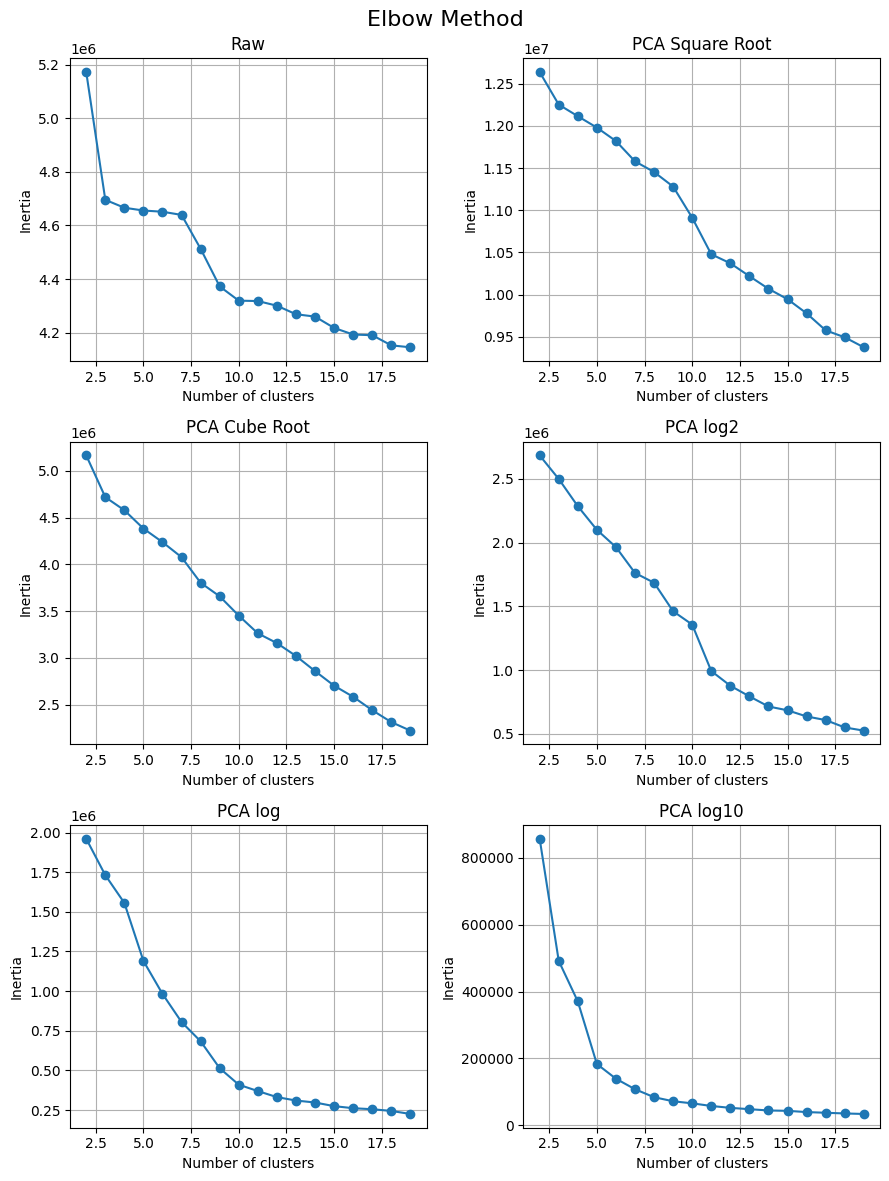

In [12]:
ev.plot_elbow()

We can see that **Raw** and **Square root** families are quite noisy, meanwhile **PCA log** and **PCA log10** families have an apprecciable smooth elbow curve.

We are going to use these two families computed in the ranges where the *elbow* is more pronounced:

In [13]:
silhouette_df = ev.silhouette({
    'PCA log2': range(8,15),
    'PCA log': range(5,11),
    'PCA log10': range(5,8)
})
silhouette_df

,model,clusters,score
7,PCA log,5,0.761422
8,PCA log,6,0.760298
9,PCA log,7,0.759496
13,PCA log10,5,0.751743
15,PCA log10,7,0.729099
14,PCA log10,6,0.729047
11,PCA log,9,0.720775
10,PCA log,8,0.718986
1,PCA log2,9,0.707357
0,PCA log2,8,0.706937
